In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd

### Check if cuda is available

In [2]:
torch.cuda.is_available()

True

### Cifar10 dataset 

In [3]:
cifar = load_dataset("cifar10",)
i = cifar["train"]["img"][0]
print(i.size)

(32, 32)


Images in cifar10 has small size 32 x 32 which is faster for training. Moreover, the dataset has 10 classes and we can see that both train and test datasets are balanced with equal number of smaples per class

In [ ]:
df_train = pd.DataFrame(cifar["train"])
df_train.groupby(by="label").count()

In [ ]:
df_test = pd.DataFrame(cifar["test"])
df_test.groupby(by="label").count()

Names of classes

In [ ]:
labels = cifar["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label
    
print(labels)

### The Model Architecture

In [4]:
class NaturalSceneClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(4096,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,10)
        )
    
    def forward(self, xb):
        return self.network(xb)

### Dataset Class

In [5]:
transform = transforms.Compose([
    # you can add other transformations in this list
     transforms.Resize((32,32)),
    transforms.ToTensor()
])

class Dataset(Dataset):
    
    # Constructor 
    def __init__(self, X_data, Y_data, transform=transform):
        self.len = len(X_data)
        self.x = X_data
        self.y = Y_data
        self.transform = transform
             
    # Getter
    def __getitem__(self, index):
        x = self.x[index] 
        y = self.y[index]
        if self.transform:
            x = self.transform(x)     
        return x, y
    
    # Get Length
    def __len__(self):
        return self.len


In [ ]:
xx = pd.DataFrame(cifar["train"][10000:-1])
xx.groupby("label").count()
#yy = pd.DataFrame(cifar["train"])
#yy.shape


In [6]:
dataset_val = Dataset( X_data = cifar["train"]["img"][0:10000], Y_data = cifar["train"]["label"][0:10000])
val_loader = DataLoader(dataset=dataset_val, batch_size=256, shuffle=True)
dataset_train = Dataset( X_data = cifar["train"]["img"][10000:-1], Y_data = cifar["train"]["label"][10000:-1])
train_loader = DataLoader(dataset=dataset_train, batch_size=256, shuffle=True)
dataset_test = Dataset( X_data = cifar["test"]["img"], Y_data = cifar["test"]["label"])
test_loader = DataLoader(dataset=dataset_test, batch_size=256, shuffle=True)

Preview an image from the dataset

In [ ]:
img,label = dataset_train[110]

def display_img(img,label):
    print(f"Label : {label}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(img, label)

Choosing the Optimizer and the Cost function

In [7]:
model = NaturalSceneClassification()
model.to("cuda:0")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_new = nn.CrossEntropyLoss()

### Training the model

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

best_loss = float('inf')
#best_model_weights = None
patience = 3

epoch_train_loss = []
epoch_train_acc = []
epoch_val_loss = []
epoch_val_acc = []

for epoch in range(15):

    train_losses = []
    train_acc = []

    val_losses = []
    val_acc = []
    val_loss_total = 0
    
    
    
    model.train()
    for x,y in train_loader:

        optimizer.zero_grad()
        x = x.to("cuda:0")
        y = y.to("cuda:0")
        output = model(x)
        loss = loss_new(output, y)
        acc = accuracy(output, y)
        
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_acc.append(acc.item())
        
    epoch_train_loss.append(sum(train_losses)/len(train_losses))
    epoch_train_acc.append(sum(train_acc)/len(train_acc))
    
        

    print("Train epoch loss", sum(train_losses)/len(train_losses), "acc", sum(train_acc)/len(train_acc))
    
    model.eval()
    with torch.no_grad():
        for x,y in val_loader:

            
            x = x.to("cuda:0")
            y = y.to("cuda:0")
            output = model(x)
            loss = loss_new(output, y)
            acc = accuracy(output, y)
            

            val_losses.append(loss.item())
            val_acc.append(acc.item())
            
    epoch_val_loss.append(sum(val_losses)/len(val_losses))
    epoch_val_acc.append(sum(val_acc)/len(val_acc))
    
    
    print("Val epoch loss", sum(val_losses)/len(val_losses), "acc", sum(val_acc)/len(val_acc))
    
    
    # Early stopping
    val_loss_total = sum(val_losses)/len(val_losses)
    if val_loss_total < best_loss:
        best_loss = val_loss_total
        #best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here      
        patience = 3  # Reset patience counter
    else:
        patience -= 1
        if patience == 0:
            break
    



Train epoch loss 1.8785261060022245 acc 0.2968149707195865
Val epoch loss 1.615708166360855 acc 0.41064453125
Train epoch loss 1.3972831402614618 acc 0.4872481139602175
Val epoch loss 1.3084523588418961 acc 0.5208984375
Train epoch loss 1.1251934447865577 acc 0.5916718798837844
Val epoch loss 1.1422437489032746 acc 0.59755859375
Train epoch loss 0.946656427945301 acc 0.6592569951039211
Val epoch loss 1.033232866227627 acc 0.639453125
Train epoch loss 0.8257655565905723 acc 0.7028694805825592
Val epoch loss 0.8765920847654343 acc 0.69443359375
Train epoch loss 0.7033712958833974 acc 0.7484633284769241
Val epoch loss 0.8137962117791175 acc 0.7138671875
Train epoch loss 0.6147220804812802 acc 0.7828668424278308
Val epoch loss 0.7573658101260662 acc 0.73857421875
Train epoch loss 0.5258461197090757 acc 0.8158896819801088
Val epoch loss 0.7410888463258744 acc 0.7453125
Train epoch loss 0.439957067844974 acc 0.8434356359919165
Val epoch loss 0.7316354498267174 acc 0.75390625
Train epoch loss

Plot Training vs. Validation loss:

This way we can check for overfitting or underfitting

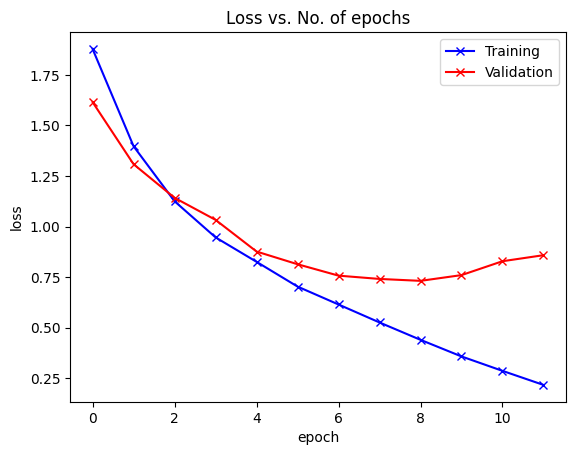

In [9]:
def plot_losses(epoch_train_loss, epoch_val_loss):
    """ Plot the losses in each epoch"""
    plt.plot(epoch_train_loss, '-bx')
    plt.plot(epoch_val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(epoch_train_loss,epoch_val_loss)


Plot Training vs. Validation Accuracy

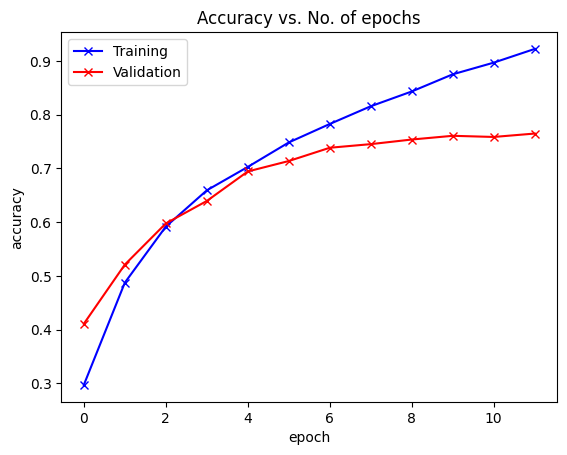

In [10]:
def plot_accuracy(epoch_train_acc, epoch_val_acc):
    """ Plot the accuracy in each epoch"""
    plt.plot(epoch_train_acc, '-bx')
    plt.plot(epoch_val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');

plot_accuracy(epoch_train_acc,epoch_val_acc)


#### Evaluating the model on the test data

In [11]:
model.eval()
with torch.no_grad():
    
    test_losses = []
    test_acc = []
    
    for x,y in test_loader:
        
        x = x.to("cuda:0")
        y = y.to("cuda:0")
        output = model(x)
        
        loss = loss_new(output, y)
        acc = accuracy(output, y)
        
        test_losses.append(loss.item())
        test_acc.append(acc.item())

    print("epoch loss", sum(test_losses)/len(test_losses), "acc", sum(test_acc)/len(test_acc))

epoch loss 0.8564269885420799 acc 0.767578125


Saving the model

In [10]:
torch.save(model.state_dict(), 'model.pth')